In [1]:
# display plots inline
%matplotlib notebook

# imports
import os
import numpy as np
import pandas as pd
import pymc3 as pm
from bambi import Model, Prior
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pymc3_utils as pmu

# suppress system warnings for legibility
import warnings
warnings.filterwarnings('ignore')

# resize plots to fit labels inside bounding box
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# MPI color scheme
sns.set(style='white', palette='Set2')

# Digit span
## Loading data

In [2]:
df_span = pd.read_csv('data/digit_span.tsv', sep='\t')
df_span = pd.melt(df_span, id_vars=['pp'], value_vars=['fds', 'bds'], var_name='task', value_name='span')
df_reading = pd.read_csv('data/tamil_reading.tsv', sep='\t')
df_span = df_span.merge(df_reading, left_on='pp', right_on='pp')

display(df_span.head())

,pp,task,span,subject,literate,word,pseudoword
0,low_1,fds,5,1,low,24,1
1,low_1,bds,4,1,low,24,1
2,y_2,fds,5,2,y,63,42
3,y_2,bds,5,2,y,63,42
4,y_3,fds,6,3,y,80,49


## Data mangling and plotting

In [3]:
# standardize variables
df_span['span_z'] = pmu.standardize(df_span['span'])
df_span['reading_z'] = pmu.standardize(df_span['word'])
df_span['task_binary'] = pd.get_dummies(df_span['task'])['fds']
df_span['task_z'] = pmu.standardize(df_span['task_binary'])

display(df_span.head())

,pp,task,span,subject,literate,word,pseudoword,span_z,reading_z,task_binary,task_z
0,low_1,fds,5,1,low,24,1,1.001956,-0.315292,1,0.997419
1,low_1,bds,4,1,low,24,1,0.358315,-0.315292,0,-0.997419
2,y_2,fds,5,2,y,63,42,1.001956,1.074860,1,0.997419
3,y_2,bds,5,2,y,63,42,1.001956,1.074860,0,-0.997419
4,y_3,fds,6,3,y,80,49,1.645596,1.680824,1,0.997419


## Modeling

First we will set some parameters for the regression procedure, as outlined in the paper.

In [4]:
# default model params
defaults = {
    'samples': 5000,
    'tune': 2500,
    'chains': 4,
    'init': 'advi+adapt_diag',
    'priors': {'fixed': 'narrow', 'random': 'narrow'},
}

We will use the only model that makes sense in the context of our multilevel model setup: A task model, an additional predictor for task type (fds versus bds) and by-participant intercepts.

In [5]:
model_span_task = Model(df_span)
model_span_task.fit('span_z ~ task_z',
                    random=['1|pp'],
                    **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 263.97:  28%|██▊       | 13956/50000 [00:07<00:19, 1858.94it/s]
Convergence achieved at 14000
Interrupted at 13,999 [27%]: Average Loss = 375.74
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [span_z_sd, 1|pp_offset, 1|pp_sd, task_z, Intercept]
Sampling 4 chains: 100%|██████████| 30000/30000 [01:23<00:00, 359.72draws/s]


In [6]:
display(pmu.summary(model_span_task.backend.trace).round(2))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,mode,n_eff,Rhat
Intercept__0,-0.00,0.08,0.0,-0.15,0.16,-0.00,6082.72,1.0
task_z__0,0.35,0.04,0.0,0.27,0.44,0.35,19005.25,1.0
1|pp_offset__0,0.72,0.56,0.0,-0.40,1.82,0.72,26527.66,1.0
1|pp_offset__1,0.04,0.55,0.0,-1.06,1.12,-0.00,21700.14,1.0
1|pp_offset__2,0.73,0.56,0.0,-0.40,1.80,0.84,21078.58,1.0
...,...,...,...,...,...,...,...,...
1|pp__93,0.47,0.36,0.0,-0.25,1.17,0.48,19655.19,1.0
1|pp__94,0.25,0.36,0.0,-0.46,0.95,0.28,22100.28,1.0
1|pp__95,0.47,0.36,0.0,-0.25,1.17,0.50,19958.59,1.0
1|pp__96,0.03,0.36,0.0,-0.66,0.74,0.03,21384.73,1.0


\\(\hat{r}\\) values look good, as does the number of effective samples for the by-participant intercepts. For the overall intercept we have more than 8K effective samples, for the span variance we have more than 5.5K.

## Plotting selected model traces

As an additional check, we will plot the posterior traces for the model. Ideally these look unimodal and roughly normal. The plots on the righthand side should look like fuzzy caterpillars.

<IPython.core.display.Javascript object>


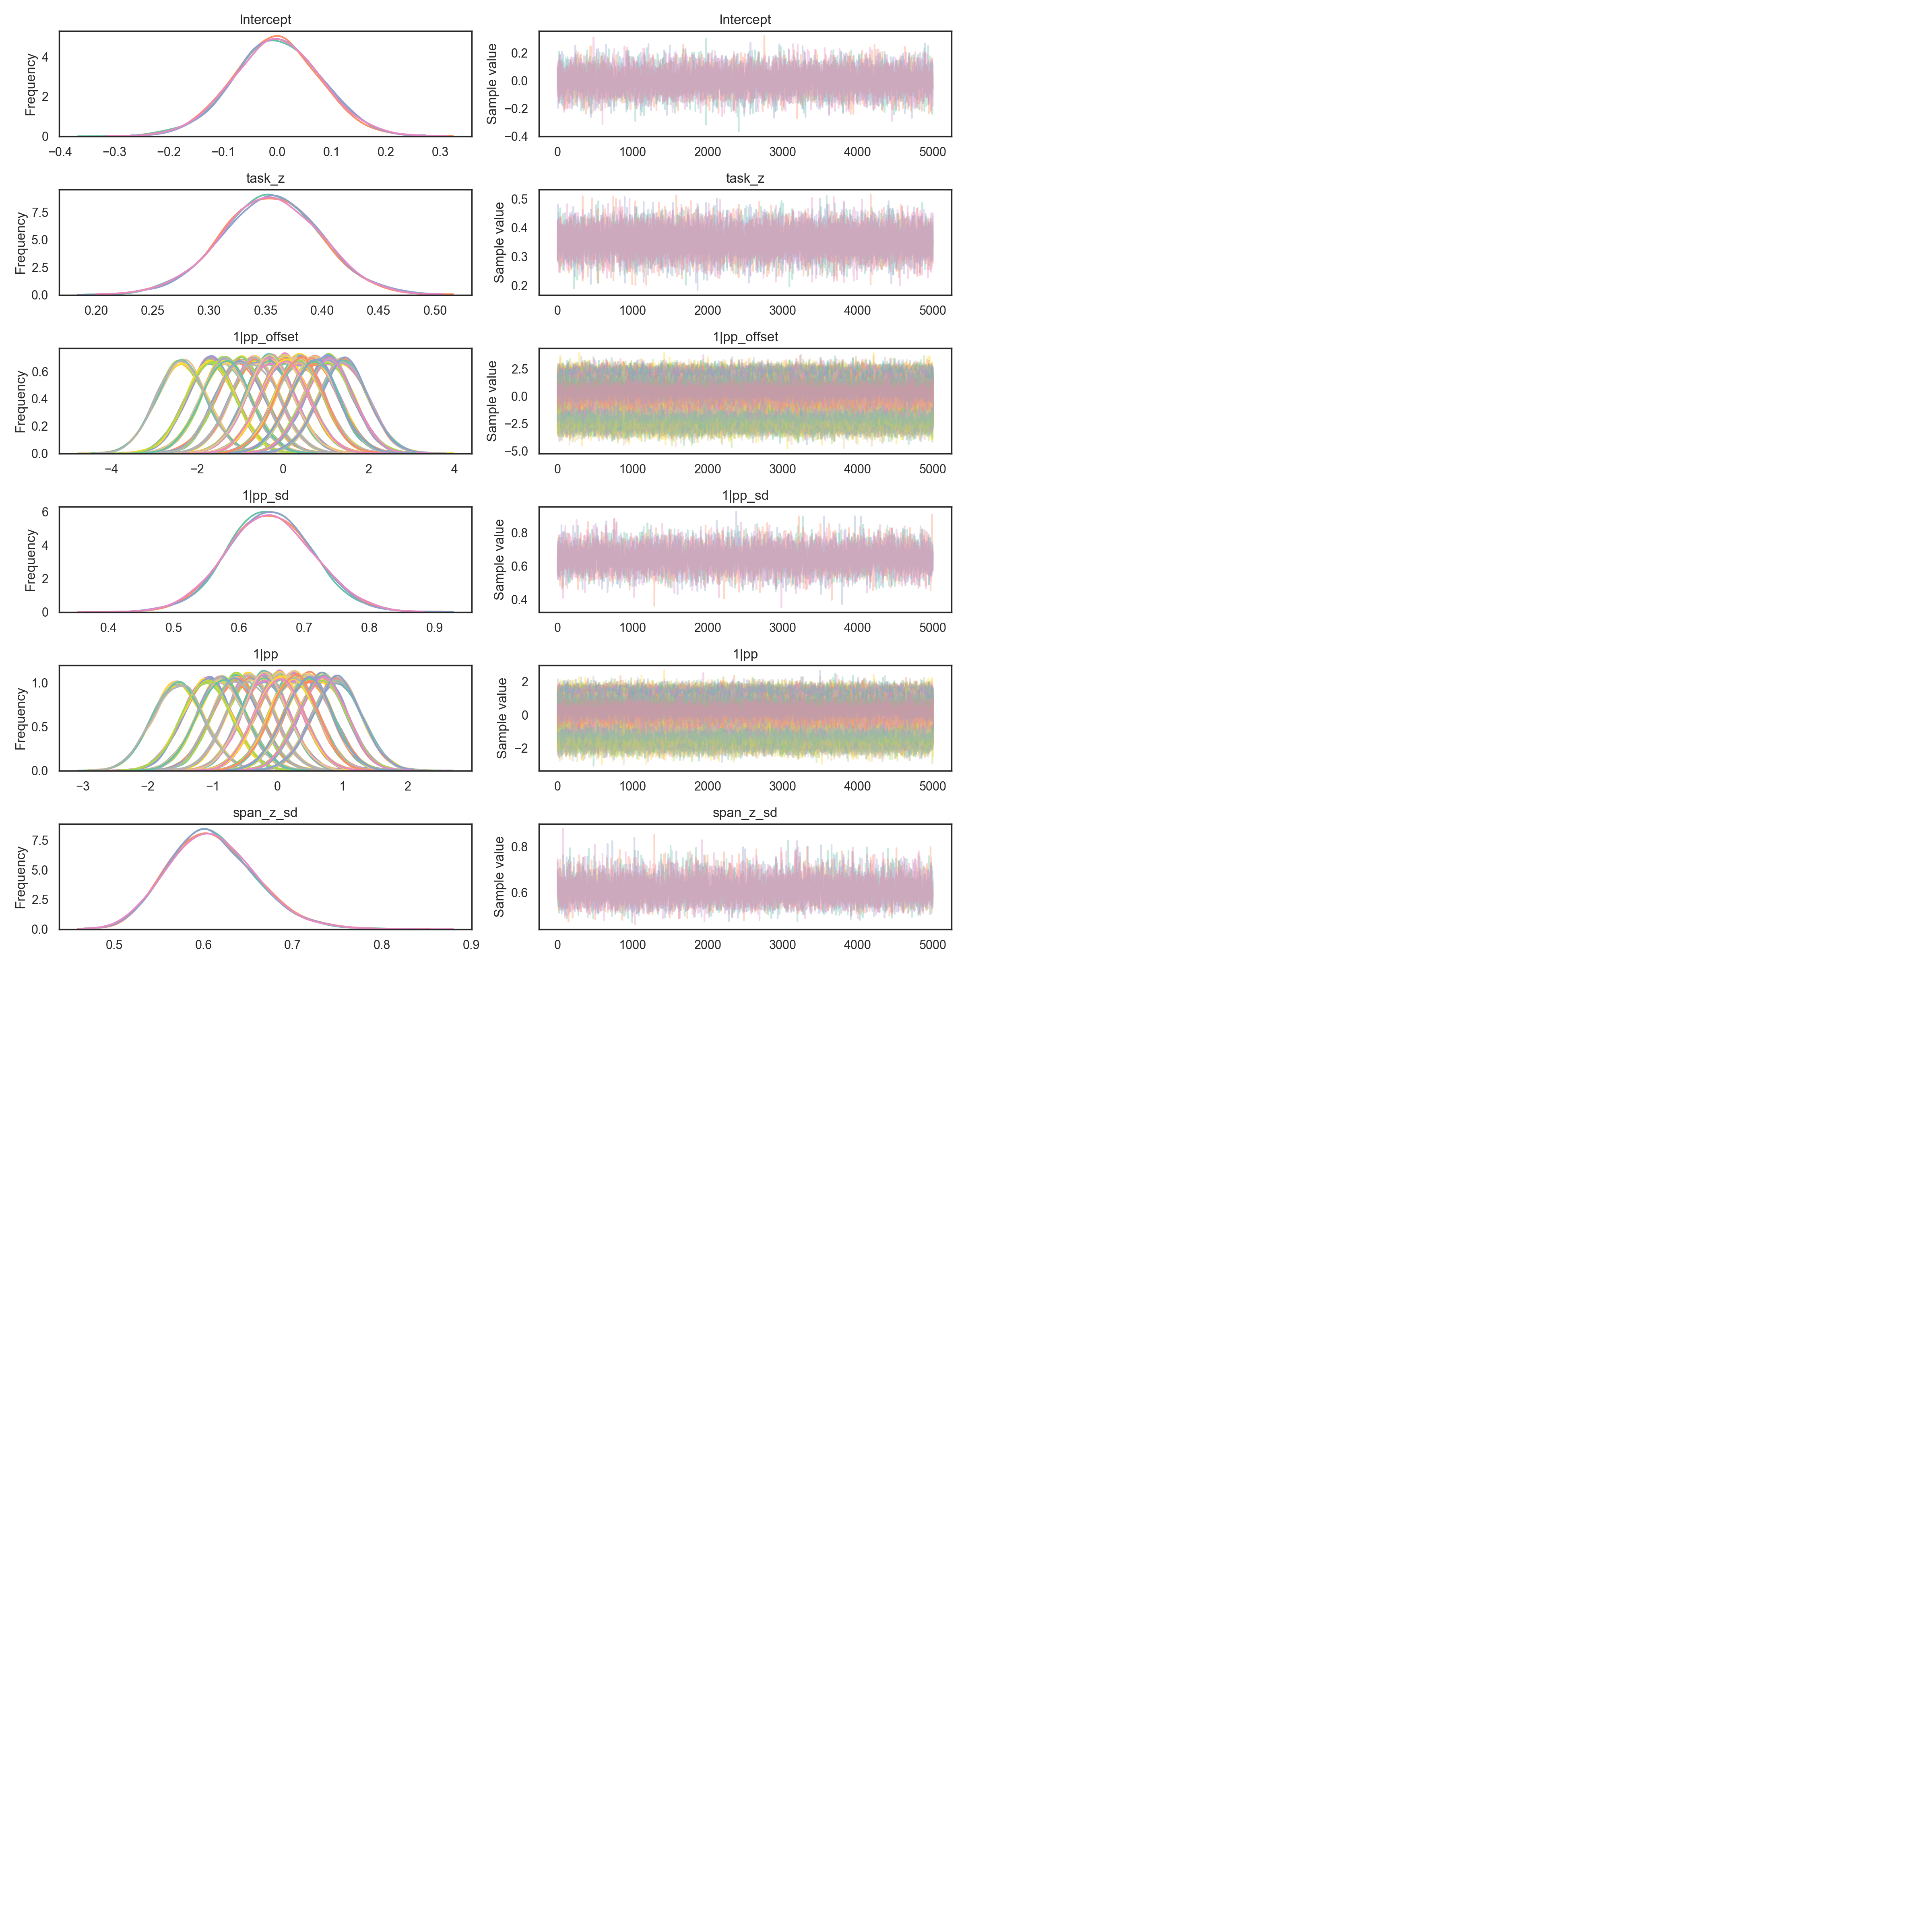

In [7]:
g_traces = pm.traceplot(model_span_task.backend.trace)
plt.savefig('figures/digit_span_model_traces.png', dpi=600)

## Extracting participant intercept modes

We will now extract and store the posterior modes of the participant intercepts so we can use them to model reading scores.

In [8]:
pps = df_span['pp'].unique()
pp_nums = [f'1|pp__{i}' for i in range(len(pps))]
df_intercepts = pmu.summary(model_span_task.backend.trace).loc[pp_nums]
df_intercepts['pp'] = np.sort(pps)

display(df_intercepts.head().round(2))

,mean,sd,mc_error,hpd_2.5,hpd_97.5,mode,n_eff,Rhat,pp
1|pp__0,0.46,0.36,0.0,-0.24,1.18,0.51,24677.85,1.0,low_1
1|pp__1,0.02,0.35,0.0,-0.66,0.73,0.00,21074.71,1.0,low_10
1|pp__2,0.47,0.36,0.0,-0.22,1.19,0.49,20026.89,1.0,low_11
1|pp__3,0.25,0.36,0.0,-0.44,0.97,0.29,21346.03,1.0,low_12
1|pp__4,0.69,0.37,0.0,-0.04,1.40,0.70,18763.55,1.0,low_13


In [9]:
df_uncorrected = df_span.groupby('pp', as_index=False).mean().rename(columns={'span': 'raw_span_mean'})
df_intercepts = df_intercepts[['pp', 'mode']].rename(columns={'mode': 'span_intercept'})
df_intercepts = df_intercepts.merge(df_uncorrected[['pp', 'reading_z', 'raw_span_mean']],
                                    left_on='pp', right_on='pp').reset_index()

display(df_intercepts.head().round(2))

,index,pp,span_intercept,reading_z,raw_span_mean
0,0,low_1,0.51,-0.32,4.5
1,1,low_10,0.00,0.65,3.5
2,2,low_11,0.49,0.36,4.5
3,3,low_12,0.29,0.01,4.0
4,4,low_13,0.70,0.01,5.0


In [10]:
# and write to file
df_intercepts.to_csv('data/span_intercepts.tsv', sep='\t')

Before closing this notebook, we will take a quick look at the correlations between working memory and reading score.

In [11]:
display(df_intercepts[['raw_span_mean', 'span_intercept', 'reading_z']].corr().round(2))

,raw_span_mean,span_intercept,reading_z
raw_span_mean,1.00,1.00,0.51
span_intercept,1.00,1.00,0.51
reading_z,0.51,0.51,1.00
